# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [2]:
!mkdir cifar10
!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  1586k      0  0:01:44  0:01:44 --:--:-- 1545k  0  2725k      0  0:01:01  0:00:15  0:00:46 1308k0:50 1114k 0:00:55  0:00:38 2124k02k      0  0:01:37  0:01:17  0:00:20 1072k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

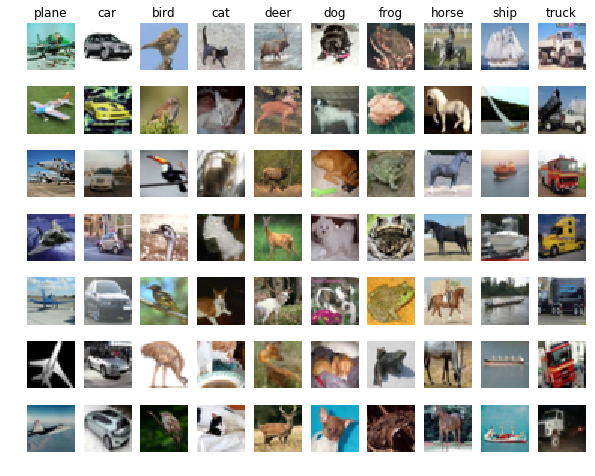

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Глубиной. И наличием фишек, нужных для того, чтобы глубокие сети обучались. Примеры фишек: batch normalization и shortcut connection. 

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Из-за глубины затухают (или взрываются) градиенты, просто потому что чем больше чисел <1 (>1) мы перемножим, тем меньшее (большее) число получим. Чем глубже сеть, тем больше параметров, чем больше параметров, тем больше риск переобучения. Думаю, что при увеличении числа параметров у функции увеличивается риск при оптимизации попасть в локальный минимум, поэтому нужна более тонкая инициализация всех параметров. Также увеличивается время обучения, что не позвоняет также эффективно применять перекрёстную проверку, как в случае простых моделей.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Основная проблема будет в переобучении, потому что малая выборка плохо определяет распределение, в случае картинок можно сделать data augmentation, добавить в выборку искажённые картинки, например перевёрнутые. Сначала нужно использовать сеть с небольшим количеством параметров, делать pooling, dropout.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Также как с картинками нужно фиксировть в опредёлённом слое активации, которые определяют само изображение.
Правда тут сложнее с тем, что определяет стиль. В случае изображений выкидывали длину и ширину и рассматривали только корреляцию между разными фильтрами. В случае музыки стиль определяется гаммой, лежащей в основе. Есть специальные блюзовые и джазовые гаммы. То есть определяется соотношениями между частотами. То есть нужно считать корреляции между частотами. 

In [17]:
import theano

In [18]:
import pygpu

In [19]:
import lasagne

In [14]:
from theano import tensor as T
from lasagne.nonlinearities import *

In [15]:
input_X = T.tensor4("X", dtype='floatX')
target_y = T.vector("target Y integer",dtype='int64')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [24]:
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import ElemwiseSumLayer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import GlobalPoolLayer
from lasagne.layers import PadLayer
from lasagne.layers import ExpressionLayer
from lasagne.layers import NonlinearityLayer, get_all_layers
from lasagne.nonlinearities import softmax, rectify
from lasagne.layers import batch_norm

In [21]:
def residual_block1(layer):    
    stack_1 = batch_norm(ConvLayer(l, num_filters=layer.output_shape[1] , filter_size=(3,3), stride=(1, 1), nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
    stack_2 = batch_norm(ConvLayer(stack_1, num_filters=layer.output_shape[1] , filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
    
    block = NonlinearityLayer(ElemwiseSumLayer([stack_2, l]),nonlinearity=rectify)
    return block

def residual_block2(layer):
    stack_1 = batch_norm(ConvLayer(l, num_filters=layer.output_shape[1] , filter_size=(3,3), stride=(2, 2), nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
    stack_2 = batch_norm(ConvLayer(stack_1, num_filters=2*layer.output_shape[1] , filter_size=(3,3), stride=(1,1), nonlinearity=None, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
 
    identity = ExpressionLayer(l, lambda X: X[:, :, ::2, ::2], lambda s: (s[0], s[1], s[2]//2, s[3]//2))
    padding = PadLayer(identity, [2*layer.output_shape[1]//4,0,0], batch_ndim=1)
    block = NonlinearityLayer(ElemwiseSumLayer([stack_2, padding]),nonlinearity=rectify)    
    
    return block

In [42]:
n=5

In [43]:
l_in = InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

l = batch_norm(ConvLayer(l_in, num_filters=16, filter_size=(3,3), stride=(1,1), nonlinearity=rectify, pad='same', W=lasagne.init.HeNormal(gain='relu'), flip_filters=False))
    
for _ in range(n):
    l = residual_block1(l)

l = residual_block2(l)
for _ in range(1,n):
    l = residual_block1(l)

l = residual_block2(l)
for _ in range(1,n):
    l = residual_block1(l)
    
l = GlobalPoolLayer(l)

ResNet = DenseLayer(l, num_units=10, W=lasagne.init.HeNormal(), nonlinearity=softmax)

In [49]:
l2_penalty = lasagne.regularization.regularize_layer_params(get_all_layers(ResNet), lasagne.regularization.l2) * 0.0025

In [45]:
y_predicted = lasagne.layers.get_output(ResNet)
all_weights = lasagne.layers.get_all_params(ResNet, trainable=True)
print all_weights

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [50]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean() + l2_penalty
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [ ]:
from lasagne.updates import nesterov_momentum, adam
updates = adam(loss, all_weights, learning_rate=0.0001)
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [29]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True, augment=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:            
            padded = np.pad(inputs[excerpt],((0,0),(0,0),(4,4),(4,4)),mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.randint(0,high=8,size=(batchsize,2))
            for r in range(batchsize):
                random_cropped[r,:,:,:] = padded[r,:,crops[r,0]:(crops[r,0]+32),crops[r,1]:(crops[r,1]+32)]
            inp_exc = random_cropped
        yield inputs[excerpt], targets[excerpt]

In [30]:
X_val = X_test[:8000]
y_val = y_test[:8000]
X_test = X_test[8000:]
y_test = y_test[8000:]

In [31]:
X_train_aug = X_train[:,:,:,::-1]
y_train_aug = y_train
print X_train_aug.shape
X_train = np.concatenate((X_train,X_train_aug),axis=0)
y_train = np.concatenate((y_train,y_train_aug),axis=0)

(50000, 3, 32, 32)


In [93]:
X_val.shape

(8000, 3, 32, 32)

In [94]:
X_train.shape

(50000, 3, 32, 32)

In [136]:
iterate_minibatches(X_val, y_val, batch_size)

<generator object iterate_minibatches at 0x7f759eb369b0>

# Процесс обучения

In [ ]:
import time

num_epochs = 60 #количество проходов по данным

batch_size = 128 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train.astype('float32'), y_train,batch_size, shuffle=True, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs.astype('float32'), targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0    
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs.astype('float32'), targets)
        val_batches += 1        
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 1 of 60 took 212.532s
  training loss (in-iteration):		0.599921
  train accuracy:		91.65 %
  validation accuracy:		88.05 %


In [33]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test.astype('float32'), y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs.astype('float32'), targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		85.55 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 